In [102]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime


In [114]:
with open('./datasets/business_dataset_new_orleans.json', 'r') as f:
    data = f.readlines()
    data = list(map(lambda x: x.rstrip(), data))
    data_json_str = "[" + ','.join(data) + "]"
    df_businesses = pd.read_json(data_json_str)
    df_businesses['business_id'] = 'biz_' + df_businesses['business_id']
    
with open('./datasets/user_dataset_new_orleans.json', 'r') as f:
    data = f.readlines()
    data = list(map(lambda x: x.rstrip(), data))
    data_json_str = "[" + ','.join(data) + "]"
    df_users = pd.read_json(data_json_str)
    
with open('./datasets/review_dataset_new_orleans.json', 'r') as f:
    data = f.readlines()
    data = list(map(lambda x: x.rstrip(), data))
    data_json_str = "[" + ','.join(data) + "]"
    df_reviews = pd.read_json(data_json_str)
    df_reviews['review_id'] = 'rev_' + df_reviews['review_id']
    df_reviews['business_id'] = 'biz_' + df_reviews['business_id']

# convert friends to list
df_users['friends'] = df_users['friends'].apply(lambda x: x.split(','))
# convert elite to list
df_users['elite'] = df_users['elite'].apply(lambda x: x.split(','))

C:\Users\maysa\AppData\Local\Temp\ipykernel_9940\4277523074.py:5: FutureWarning:

Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\maysa\AppData\Local\Temp\ipykernel_9940\4277523074.py:12: FutureWarning:

Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\maysa\AppData\Local\Temp\ipykernel_9940\4277523074.py:18: FutureWarning:

Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



In [115]:
user_ids_set = set(df_users['user_id'])

def remove_non_existing_friends(friends):
    return list(set(friends) & user_ids_set)

print("Before removing non-existing friends:", df_users['friends'].apply(len).sum())

df_users['friends'] = df_users['friends'].apply(remove_non_existing_friends)

print("After removing non-existing friends:", df_users['friends'].apply(len).sum())
print("------------------------------------")
print("Before removing users with no friends:", len(df_users))

df_users = df_users[df_users['friends'].apply(len) > 0]

print("After removing users with no friends:", len(df_users))


Before removing non-existing friends: 18945313
After removing non-existing friends: 14555
------------------------------------
Before removing users with no friends: 245354
After removing users with no friends: 14555


In [116]:
print("Before removing reviews with non-existant users: ", len(df_reviews))

# remove review if user is not in the graph
df_reviews = df_reviews[df_reviews['user_id'].isin(df_users['user_id'])]

print("After removing: ", len(df_reviews))

print("------------------------------------")

print("Before removing users with less than 2 reviews: ", len(df_users))

# remove user if they have less than 2 reviews
df_users = df_users[df_users['review_count'] >= 2]

print("After removing: ", len(df_users))

print("------------------------------------")

print("Before removing reviews of non-existant businesses: ", len(df_reviews))

# remove review if business is not in the graph
df_reviews = df_reviews[df_reviews['business_id'].isin(df_businesses['business_id'])]

print("After removing: ", len(df_reviews))

Before removing reviews with non-existant users:  635364
After removing:  90306
------------------------------------
Before removing users with less than 2 reviews:  14555
After removing:  13769
------------------------------------
Before removing reviews of non-existant businesses:  90306
After removing:  90306


In [117]:
print("Before removing businesses with no reviews: ", len(df_businesses))

# remove business if they have less than 2 reviews
df_businesses = df_businesses[df_businesses['review_count'] >= 1]

print("After removing: ", len(df_businesses))

print("------------------------------------")

print("Before bussinesses that are not opened: ", len(df_businesses))

# remove businesses that are not opened
df_businesses = df_businesses[df_businesses['is_open'] == 1]

print("After removing: ", len(df_businesses))

Before removing businesses with no reviews:  6209
After removing:  6209
------------------------------------
Before bussinesses that are not opened:  6209
After removing:  4649


In [127]:
# remove reviews if they are not in the business dataset
df_reviews = df_reviews[df_reviews['business_id'].isin(df_businesses['business_id'])]

# reset indexes
df_businesses.reset_index(drop=True, inplace=True)
df_users.reset_index(drop=True, inplace=True)
df_reviews.reset_index(drop=True, inplace=True)

In [6]:
import plotly.graph_objects as go

lats = df_businesses['latitude']
lons = df_businesses['longitude']
names = df_businesses['name']
stars = df_businesses['stars']

colors = []
for star in stars:
    if star >= 4.0:
        colors.append('green')
    elif star >= 3.0:
        colors.append('yellow')
    else:
        colors.append('red')
        

fig = go.Figure(go.Scattermapbox(
        lat=lats,
        lon=lons,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=3,
            color=colors,
            opacity=0.7
        ),
        text=names,
    ))
legend_entries = [
    {'label': 'Rating >= 4.5', 'color': 'green'},
    {'label': '4.0 <= Rating < 4.5', 'color': 'yellow'},
    {'label': 'Rating < 4.0', 'color': 'red'}
]

for entry in legend_entries:
    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        marker=dict(size=0),
        showlegend=True,
        name=entry['label'],
        line=dict(color=entry['color'])
    ))

fig.update_layout(
    title= "Business Locations in New Orleans",
    autosize = True,
    hovermode='closest',
    mapbox =dict(
        accesstoken="pk.eyJ1IjoidG9tYXNnNyIsImEiOiJjbHVuNWtsOWEwZnNlMmpwbmtqM2gwa213In0.8cGFuz6zBfMNItCu791cYQ",
        bearing=0,
        center=dict(
            lat=30.0,
            lon=-90.0
        ),
        pitch=0,
        zoom=10
    ),
)

fig.show()
    

In [7]:
# top 5 categories
df_businesses['categories'] = df_businesses['categories'].fillna('')
categories = df_businesses['categories'].apply(lambda x: x.split(','))
categories = categories.explode()
categories = categories.value_counts()
categories = categories[:5]

fig = go.Figure(go.Bar(
    x=categories.index,
    y=categories.values
))

fig.update_layout(
    title="Top 5 Categories",
    xaxis_title="Category",
    yaxis_title="Count"
)

fig.show()

In [29]:
ratings = df_reviews['stars'].value_counts()

# Calcular a porcentagem de cada classificação
total_ratings = ratings.sum()
percentage_ratings = (ratings / total_ratings) * 100

# Criar texto para exibir a porcentagem em cada barra
text = [f'{count} ({percentage:.2f}%)' for count, percentage in zip(ratings.values, percentage_ratings.values)]

fig = go.Figure(go.Bar(
    x=ratings.index,
    y=ratings.values,
    text=text,  
    textposition='auto',
))

fig.update_layout(
    title="Distribution of User Ratings",
    xaxis_title="Rating",
    yaxis_title="Count"
)

fig.show()


13769
Number of nodes:  13769


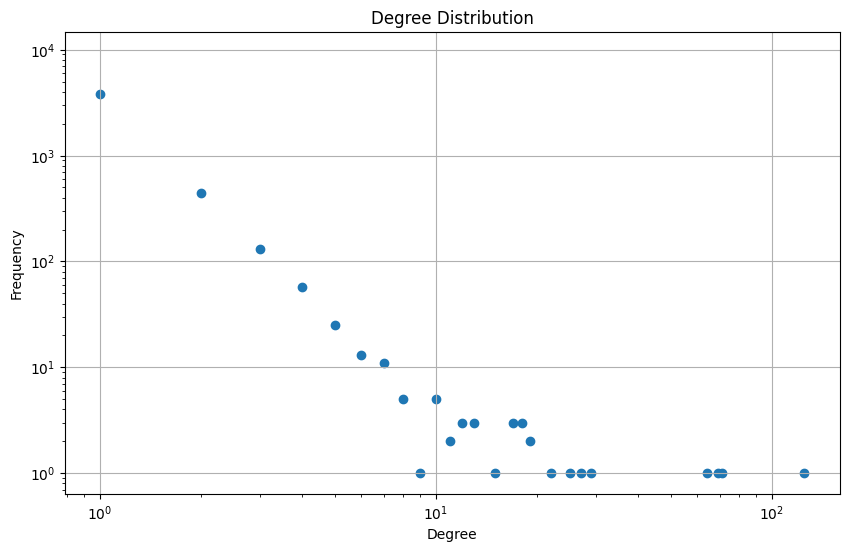

Nodes and edges: 13769 3179


In [9]:
network = nx.Graph()

print(len(df_users['user_id']))

network.add_nodes_from(df_users['user_id'])



for user,friends in zip(df_users['user_id'], df_users['friends']):
    for friend in friends:
        if friend in df_users['user_id'].values:
            network.add_edge(user, friend)

print("Number of nodes: ", network.number_of_nodes())
# sorted list with degree of each node
degree_sequence = sorted([d for n, d in network.degree()], reverse=True)

degree_freq = {}
for degree in degree_sequence:
    if degree in degree_freq:
        degree_freq[degree] += 1
    else:
        degree_freq[degree] = 1


# create degree distribution plot, not histogram
plt.figure(figsize=(10, 6))
plt.scatter(degree_freq.keys(), degree_freq.values())
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Frequency')
plt.xlabel('Degree')
plt.grid(True)
plt.title('Degree Distribution')
plt.show()

print("Nodes and edges:", network.number_of_nodes(), network.number_of_edges())

In [10]:
# len of list where degree is better than 10
topX = len([d for n, d in network.degree() if d > 10])
print(topX)

# remove isolated
network.remove_nodes_from(list(nx.isolates(network)))

25


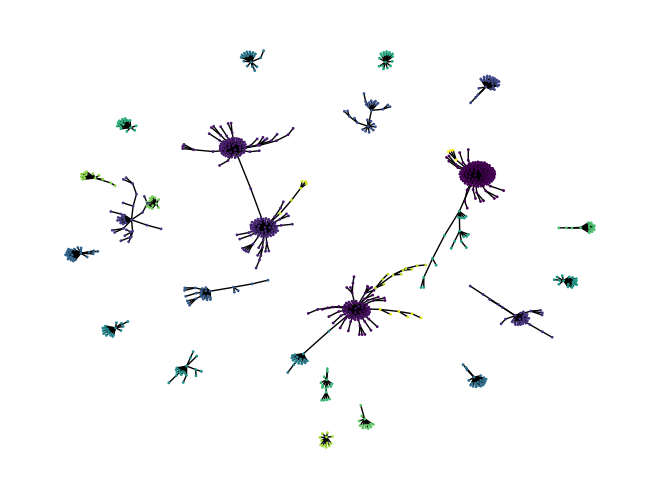

In [11]:
# Subgraph induced by node with higher degree
max_degree_node = sorted(dict(network.degree()).items(), key=lambda x: x[1], reverse=True)[:topX]
max_degree_node_ids = [node[0] for node in max_degree_node]
subgraph_nodes = set()

for node in max_degree_node_ids:
    subgraph_nodes |= set(nx.node_connected_component(network, node))

g_sub = network.subgraph(subgraph_nodes)

# Communities 
communities = nx.community.greedy_modularity_communities(g_sub)

node_to_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_community[node] = i

# Color nodes by community
colors = [node_to_community[node] for node in g_sub.nodes()]

pos = nx.spring_layout(g_sub)
nx.draw(g_sub, pos, node_color=colors, node_size=1, with_labels=False)
plt.show()


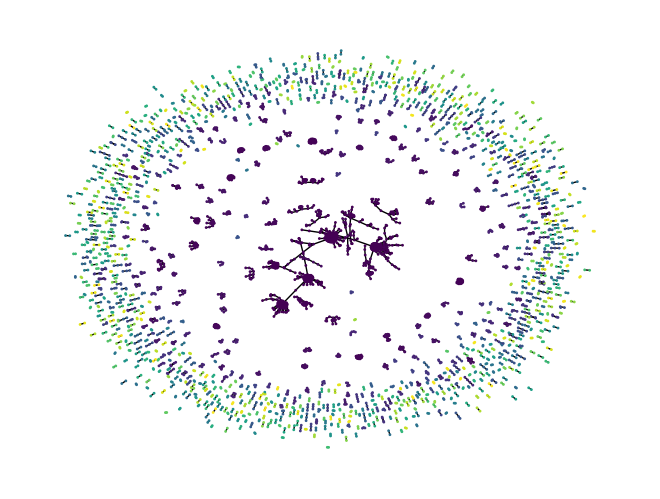

In [12]:
# find communities in main graph
communities = nx.community.greedy_modularity_communities(network)

node_to_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_community[node] = i

# Color nodes by community
colors = [node_to_community[node] for node in network.nodes()]

pos = nx.spring_layout(network)
nx.draw(network, pos, node_color=colors, node_size=1, with_labels=False)
plt.show()

In [13]:
# print number of nodes, edges 
print("Nodes and edges:", network.number_of_nodes(), network.number_of_edges())

Nodes and edges: 4500 3179


In [14]:
betwenness = nx.betweenness_centrality(network)

sorted_betweenness = sorted(betwenness.items(), key=lambda x: x[1], reverse=True)

elite_users = list(df_users[df_users['elite'].apply(len) > 0]['user_id'])

top_percent = 10
top_nodes = sorted_betweenness[:int(len(sorted_betweenness) * top_percent / 100)]
elite_users_in_top = sum(1 for node in top_nodes if node[0] in elite_users)
percentage_elite = elite_users_in_top / len(top_nodes) * 100

print(f"Percentage of elite users in top {top_percent}% of users by betweenness centrality: {percentage_elite}%")

Percentage of elite users in top 10% of users by betweenness centrality: 100.0%


In [15]:
degree = nx.degree_centrality(network)

sorted_degree = sorted(degree.items(), key=lambda x: x[1], reverse=True)

top_nodes = sorted_degree[:int(len(sorted_degree) * top_percent / 100)]
elite_users_in_top = sum(1 for node in top_nodes if node[0] in elite_users)
percentage_elite = elite_users_in_top / len(top_nodes) * 100

print(f"Percentage of elite users in top {top_percent}% of users by degree centrality: {percentage_elite}%")

Percentage of elite users in top 10% of users by degree centrality: 100.0%


In [16]:
page_rank = nx.pagerank(network)

sorted_page_rank = sorted(page_rank.items(), key=lambda x: x[1], reverse=True)

top_nodes = sorted_page_rank[:int(len(sorted_page_rank) * top_percent / 100)]
elite_users_in_top = sum(1 for node in top_nodes if node[0] in elite_users)
percentage_elite = elite_users_in_top / len(top_nodes) * 100

print(f"Percentage of elite users in top {top_percent}% of users by page rank: {percentage_elite}%")

Percentage of elite users in top 10% of users by page rank: 100.0%


In [17]:
# total num of reviews for elite and non-elite users
elite_users_reviews = df_reviews[df_reviews['user_id'].isin(elite_users)]
non_elite_users_reviews = df_reviews[~df_reviews['user_id'].isin(elite_users)]

elite_users_reviews_count = len(elite_users_reviews)
non_elite_users_reviews_count = len(non_elite_users_reviews)

print(f"Total number of reviews by elite users: {elite_users_reviews_count}")
print(f"Total number of reviews by non-elite users: {non_elite_users_reviews_count}")

Total number of reviews by elite users: 89516
Total number of reviews by non-elite users: 790


In [18]:
user_grouped_reviews = df_reviews.groupby(['user_id', 'business_id'])['stars'].mean().reset_index()

user_reviews = {}

for user,group in user_grouped_reviews.groupby('user_id'):
    user_reviews[user] = group.set_index('business_id')['stars'].to_dict()
    
# print user reviews index 0 
print(user_reviews[list(user_reviews.keys())[0]])

{'biz_GBTPC53ZrG1ZBY3DT8Mbcw': 4.0, 'biz_LY6hHivaMJIPJNv_3oBIPQ': 1.0, 'biz_hLlDzRaDGN-0SlEWk0xTpQ': 5.0, 'biz_mnq8JNUjIBwUoLBk-b2V9g': 4.0}


In [19]:
network_copy = network.copy()

def calc_similarity(common_businesses,reviews1, reviews2):

    stars1 = np.array([reviews1[b] for b in common_businesses])
    stars2 = np.array([reviews2[b] for b in common_businesses])
    
    return np.corrcoef(stars1, stars2)[0, 1]  

edges = []
for user1, user2 in combinations(network.nodes(), 2):
    reviews1 = user_reviews.get(user1, {})
    reviews2 = user_reviews.get(user2, {})
    
    common_businesses = set(reviews1.keys()) & set(reviews2.keys())
    
    common_reviews_count = len(common_businesses)
    
    if common_reviews_count >= 10:
        similarity = calc_similarity(common_businesses, reviews1, reviews2)
        
        if similarity > 0.8:
            edges.append((user1, user2, similarity))

print(edges[0:5])


c:\Users\maysa\anaconda3\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

c:\Users\maysa\anaconda3\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning:

invalid value encountered in divide



[('v9VCObZVWhOPdm1rKt8Dvg', 'mK4gA84dV7jhG_Ll0mWGfQ', 0.8072073527955752), ('iZpzJ9k4dDgBjuC27MbjvQ', 'uUrpYFU-D-U76NRv5aVDdw', 0.8544783984006463), ('iZpzJ9k4dDgBjuC27MbjvQ', 'ovUBZdJI16y-qasoqnGt5Q', 0.8623482593486368), ('Xw7ZjaGfr0WNVt6s_5KZfA', 'QjNjElXTj84bnayRGlzuWA', 0.8093691316542229), ('EP8o8JnQSI0WEkeodwA8lA', '82dCHyU-ANOgdhxUgZsUeg', 0.8553989227683015)]


In [20]:
for edge in edges:
    network_copy.add_edge(edge[0], edge[1])
    

print("Nodes and edges:", network_copy.number_of_nodes(), network_copy.number_of_edges())

Nodes and edges: 4500 3207


In [21]:
# len of list where degree is better than 10
topX = len([d for n, d in network_copy.degree() if d > 10])
print(topX)

# remove isolated
network_copy.remove_nodes_from(list(nx.isolates(network_copy)))

25


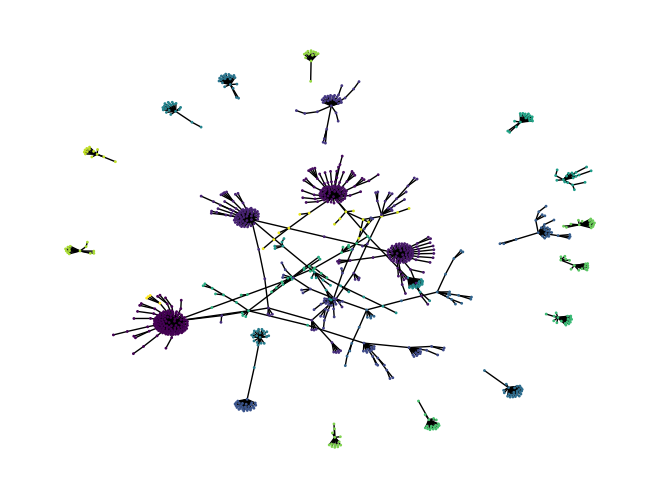

In [22]:
# Subgraph induced by node with higher degree
max_degree_node = sorted(dict(network_copy.degree()).items(), key=lambda x: x[1], reverse=True)[:topX]
max_degree_node_ids = [node[0] for node in max_degree_node]
subgraph_nodes = set()

for node in max_degree_node_ids:
    subgraph_nodes |= set(nx.node_connected_component(network_copy, node))

g_sub = network_copy.subgraph(subgraph_nodes)

# Communities 
sub_communities = nx.community.greedy_modularity_communities(g_sub)

node_to_community = {}
for i, community in enumerate(sub_communities):
    for node in community:
        node_to_community[node] = i

# Color nodes by community
colors = [node_to_community[node] for node in g_sub.nodes()]

pos = nx.spring_layout(g_sub)
nx.draw(g_sub, pos, node_color=colors, node_size=1, with_labels=False)
plt.show()

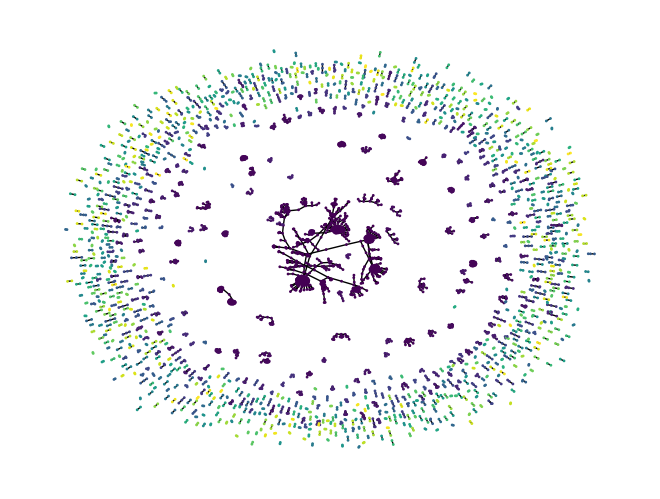

In [23]:
# Communities 
communities_2 = nx.community.greedy_modularity_communities(network_copy)

node_to_community_2 = {}
for i, community in enumerate(communities_2):
    for node in community:
        node_to_community_2[node] = i

# Color nodes by community
colors = [node_to_community_2[node] for node in network_copy.nodes()]

pos = nx.spring_layout(network_copy)
nx.draw(network_copy, pos, node_color=colors, node_size=1, with_labels=False)
plt.show()
    

# Recomender systems

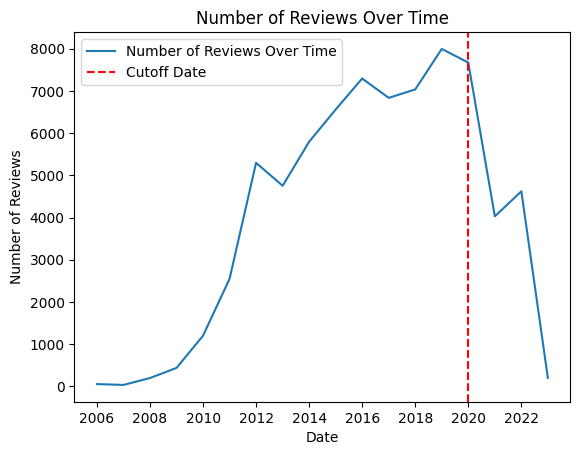

In [154]:
from surprise import SVD, Dataset, Reader,NormalPredictor, KNNBasic, KNNWithZScore, KNNWithMeans, KNNWithZScore, SVD
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy

reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(df_reviews[['user_id', 'business_id', 'stars']], reader)

# build trainset in a way that 80% are reviews from the past and 20% are the most recent reviews
df_reviews_sorted = df_reviews.sort_values(by='date')

total_reviews = len(df_reviews_sorted)

cutoff_index = int(total_reviews * 0.8)

cutoff_data = df_reviews_sorted.iloc[cutoff_index]['date']

train_data = df_reviews_sorted[df_reviews_sorted['date'] < cutoff_data]
test_data = df_reviews_sorted[df_reviews_sorted['date'] >= cutoff_data]

reviews_over_year = df_reviews_sorted.resample('YE', on='date').size()
cutoff_index = int(len(reviews_over_year) * 0.8)

cutoff_date = reviews_over_year.index[cutoff_index]

plt.figure
plt.plot(reviews_over_year.index, reviews_over_year.values, label='Number of Reviews Over Time')
plt.axvline(cutoff_date, color='red', linestyle='--', label='Cutoff Date')
plt.title('Number of Reviews Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.legend()
plt.show()

In [155]:
trainset = Dataset.load_from_df(train_data[['user_id', 'business_id', 'stars']], reader).build_full_trainset() # past reviews
testset = list(test_data[['user_id', 'business_id', 'stars']].itertuples(index=False, name=None)) # most recent reviews

In [161]:
from surprise import SVD, Dataset, Reader,NormalPredictor, KNNBasic, KNNWithZScore, KNNWithMeans, KNNWithZScore, SVD
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy
from time import time

def evaluate_algorithm(algo, trainset, testset):
    start_train_time = time()
    algo.fit(trainset)
    end_train_time = time()
    train_time = end_train_time - start_train_time
    
    start_test_time = time()
    predictions = algo.test(testset)
    end_test_time = time()
    test_time = end_test_time - start_test_time
    
    rmse = accuracy.rmse(predictions)
    
    return rmse, train_time, test_time

reader = Reader(rating_scale=(0.5, 5))

data = Dataset.load_from_df(user_grouped_reviews[['user_id', 'business_id', 'stars']], reader)

benchmark = []
for algorithm in [SVD(), KNNBasic(), KNNWithZScore(), KNNWithMeans(), KNNWithZScore(), NormalPredictor()]:
    # use train and test data
    results = evaluate_algorithm(algorithm, trainset, testset)
    
    tmp = pd.DataFrame.from_dict({'RMSE': [results[0]], 'Train Time': [results[1]], 'Test Time': [results[2]]})
    tmp['Algorithm'] = str(algorithm).split('.')[-1].split(' ')[0]
    benchmark.append(tmp)

df_benchmark = pd.concat(benchmark)
df_benchmark.set_index('Algorithm').sort_values('RMSE')
df_benchmark

RMSE: 1.1458
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2202
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2406
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2348
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2406
RMSE: 1.5742


,RMSE,Train Time,Test Time,Algorithm
0,1.145833,0.702238,0.084416,SVD
0,1.220170,2.019170,0.489992,KNNBasic
0,1.240648,2.419779,0.513674,KNNWithZScore
0,1.234789,2.189573,0.497279,KNNWithMeans
0,1.240648,2.656283,0.563343,KNNWithZScore
0,1.574190,0.037477,0.068686,NormalPredictor


In [162]:
from surprise.model_selection import GridSearchCV

param_grid = {
    'n_epochs': [5, 10, 15],          
    'lr_all': [0.002, 0.005, 0.01],   
    'reg_all': [0.02, 0.04, 0.06]      
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)

gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

1.0850560558417166
{'n_epochs': 15, 'lr_all': 0.01, 'reg_all': 0.06}


In [178]:
def get_cf_recommendations(user_id, n):
    user_reviews = user_grouped_reviews[user_grouped_reviews['user_id'] == user_id]
    
    reader = Reader(rating_scale=(0.5, 5))
    
    data = Dataset.load_from_df(user_reviews[['user_id', 'business_id', 'stars']], reader)
    
    algo = SVD(n_epochs=15, lr_all=0.01, reg_all=0.06)
    
    trainset = data.build_full_trainset()
    
    algo.fit(trainset)
    
    business_ids = list(user_grouped_reviews['business_id'].unique())
    for business_id in user_reviews['business_id']:
        # if business is already reviewed by the user, remove it 
        if business_id in business_ids:
            business_ids.remove(business_id)

    predictions = []
    for business_id in business_ids:
        predictions.append((business_id, algo.predict(user_id, business_id).est))
    
    top_n_preds = sorted(predictions, key=lambda x: x[1], reverse=True)[:n]
    top_n_business_ids = [x[0] for x in top_n_preds]
    top_n_businesses = df_businesses[df_businesses['business_id'].isin(top_n_business_ids)]
    
    return top_n_businesses[['business_id', 'categories', 'stars']]

user_id = user_grouped_reviews['user_id'].sample(1).values[0]

print("User:", user_id)
print(get_cf_recommendations(user_id, 5))
        
    

User: Xw7ZjaGfr0WNVt6s_5KZfA
                     business_id  \
148   biz_GBTPC53ZrG1ZBY3DT8Mbcw   
582   biz_PGNNRAzmml6vivxaLsrORA   
1234  biz_mnq8JNUjIBwUoLBk-b2V9g   
1245  biz_LY6hHivaMJIPJNv_3oBIPQ   
2929  biz_hLlDzRaDGN-0SlEWk0xTpQ   

                                             categories  stars  
148   German, Restaurants, Seafood, Cocktail Bars, F...    4.0  
582                             Auto Repair, Automotive    4.5  
1234  Juice Bars & Smoothies, Sandwiches, Restaurant...    4.0  
1245                                 Vegan, Restaurants    4.5  
2929          Food, Bakeries, Cafes, Restaurants, Vegan    4.5  


In [179]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

df_businesses['categories'] = df_businesses['categories'].fillna('')
df_businesses['categories'] = df_businesses['categories'].apply(lambda x: x.replace(',', ' '))
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_businesses['categories'])

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

def get_similar_businesses(business_id, n):
    idx = df_businesses[df_businesses['business_id'] == business_id].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    top_businesses = []
    for i in range(1, n+1):
        top_businesses.append(df_businesses.iloc[sim_scores[i][0]])
    
    return top_businesses

In [180]:
user_grouped_reviews = df_reviews.groupby(['user_id', 'business_id'])['stars'].mean().reset_index()

def get_cb_recommendations(user_id, n):
    user_reviews = user_grouped_reviews[user_grouped_reviews['user_id'] == user_id]
    
    cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
    recommended_businesses = []
    for business_id in user_reviews['business_id']:
        bus = df_businesses.loc[df_businesses['business_id'] == business_id]
        business_idx = bus.index[0]
        sim_scores = list(enumerate(cosine_sim_matrix[business_idx]))
        sorted_businesses = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:n+1]
        recommended_businesses += sorted_businesses
    
    recommended_businesses_ids = [x[0] for x in recommended_businesses]
    recommended_businesses_data = df_businesses[df_businesses.index.isin(recommended_businesses_ids)]
    top_n_businesses = recommended_businesses_data.groupby(['business_id','categories','stars']).size().reset_index(name='count').sort_values('count', ascending=False).head(n)
    
    return top_n_businesses[['business_id', 'categories', 'stars']]

user_id = user_grouped_reviews['user_id'].sample(1).values[0]
print("User:", user_id)
print(get_cb_recommendations(user_id, 5))

User: iT1AA74QFn_a0Xq9-ggSGA
                    business_id  \
0    biz_--x_BmZbxzK_nx_GHBaRVw   
670  biz_flr22rkcBITW_8NntgCKUw   
642  biz_e3Ue5jwrgC62LOG6vyfaLQ   
643  biz_e42VEvA54BcgYadQ5dtykw   
644  biz_e4ufPiOnXhQZxdX2XDfDRA   

                                            categories  stars  
0    Arts & Entertainment  Cinema  Local Flavor  Ho...    4.5  
670               Latin American  Mexican  Restaurants    4.5  
642                Dive Bars  Lounges  Bars  Nightlife    4.0  
643                     Restaurants  Sandwiches  Pizza    4.0  
644                              Piano Bars  Nightlife    3.5  


In [181]:
def get_hybrid_recommendations(user_id, n):
    cf_recommendations = get_cf_recommendations(user_id, n*2)
    #print("COLLAB FILTER: ", cf_recommendations)
    cb_recommendations = get_cb_recommendations(user_id, n*2)
    #print("CONTENT BASED: ", cb_recommendations)
    
    hybrid_recommendations = pd.concat([cf_recommendations, cb_recommendations])
    
    hybrid_recommendations = hybrid_recommendations.groupby(['business_id', 'categories', 'stars'])['business_id'].count().reset_index(name='count')
    
    hybrid_recommendations = hybrid_recommendations.sort_values(by=['count', 'stars'], ascending=False)
    
    hybrid_recommendations = hybrid_recommendations.head(n)
    #print("HYBRID: ", hybrid_recommendations)
    return hybrid_recommendations[['business_id', 'categories', 'stars']]

user_id = user_grouped_reviews['user_id'].sample(1).values[0]
print("User:", user_id)
print(get_hybrid_recommendations(user_id, 5))

User: WiN49ngqAfvLq32aDPIksw
                   business_id  \
1   biz_AZ42H2kk4JUiskC9NPoUjw   
3   biz_LY6hHivaMJIPJNv_3oBIPQ   
5   biz_PGNNRAzmml6vivxaLsrORA   
8   biz__-y80XtqB8fDyFtXo1mD6Q   
11  biz_c3gwn7_ukRwGGIghHLi-UA   

                                           categories  stars  
1   Bars  Cajun/Creole  Nightlife  American (Tradi...    4.5  
3                                  Vegan  Restaurants    4.5  
5                             Auto Repair  Automotive    4.5  
8   Landmarks & Historical Buildings  Public Servi...    4.5  
11                    Breakfast & Brunch  Restaurants    4.5  


In [182]:
# TO CHECK IF THE RECOMMENDATIONS ARE GOOD
# print all user reviews of a specific id and the catregories of each business he reviewed

user_reviews = user_grouped_reviews[user_grouped_reviews['user_id'] == user_id]

for business_id in user_reviews['business_id']:
    business = df_businesses[df_businesses['business_id'] == business_id]
    print(f"Business: {business['name'].values[0]}")
    print(f"Categories: {business['categories'].values[0]}")
    print(f"Rating: {user_reviews[user_reviews['business_id'] == business_id]['stars'].values[0]}")
    print("-------------------------------------------------")

Business: Palace Café
Categories: Seafood  Restaurants  Cafes  Cajun/Creole  American (New)
Rating: 5.0
-------------------------------------------------
Business: French Market Inn
Categories: Event Planning & Services  Hotels  Hotels & Travel
Rating: 3.0
-------------------------------------------------
Business: The National WWII Museum
Categories: Hotels & Travel  Arts & Entertainment  Tours  Public Services & Government  Landmarks & Historical Buildings  Museums
Rating: 3.0
-------------------------------------------------
Business: Johnny's Po-Boys
Categories: Breakfast & Brunch  Restaurants  Sandwiches
Rating: 4.0
-------------------------------------------------
Business: NOLA Restaurant
Categories: Cajun/Creole  American (New)  Southern  Restaurants
Rating: 5.0
-------------------------------------------------
Business: Mulate's
Categories: Restaurants  Seafood  Nightlife  Cajun/Creole
Rating: 2.0
-------------------------------------------------
Business: Felix's Restaurant &

In [25]:
# sort both communities
communities = sorted(communities, key=lambda x: len(x), reverse=True)
communities_2 = sorted(communities_2, key=lambda x: len(x), reverse=True)

print("FIRST GRAPH WITH ONLY FRIENDS AS EDGES:")
print("Number of communities: ", len(communities))
# top 5 communities
for i, community in enumerate(communities[:5]):
    print(f"Community {i+1}: {len(community)} users")

print("------------------------------------")
print("SECOND GRAPH WITH SIMILARITY > 0.8 AS EDGES:")
print("Number of communities: ", len(communities_2))
# top 5 communities
for i, community in enumerate(communities_2[:5]):
    print(f"Community {i+1}: {len(community)} users")



FIRST GRAPH WITH ONLY FRIENDS AS EDGES:
Number of communities:  1324
Community 1: 141 users
Community 2: 111 users
Community 3: 90 users
Community 4: 88 users
Community 5: 37 users
------------------------------------
SECOND GRAPH WITH SIMILARITY > 0.8 AS EDGES:
Number of communities:  1299
Community 1: 143 users
Community 2: 111 users
Community 3: 96 users
Community 4: 92 users
Community 5: 62 users


In [26]:
community_matrices_2 = {}

# Iterar sobre as 5 maiores comunidades do segundo grafo
for i, community in enumerate(communities_2[:5]):
    
    nodes = list(community)

    # Filtre as avaliações dos usuários pertencentes à comunidade
    community_reviews = user_grouped_reviews[user_grouped_reviews['user_id'].isin(nodes)]
    
    # Crie a matriz de usuário-item para a comunidade
    user_item_matrix = community_reviews.pivot(index='user_id', columns='business_id', values='stars')
    
    # Armazene a matriz no dicionário de matrizes da comunidade
    community_matrices_2[i] = user_item_matrix
    
    # Exiba as informações sobre a comunidade
    print(f"Community {i} has {len(nodes)} users and {user_item_matrix.shape[1]} businesses")

# get sparsity of each matrix
for i, matrix in community_matrices_2.items():
    print(f"{matrix.notnull().sum().sum() / (matrix.shape[0] * matrix.shape[1]):.2%}")

Community 0 has 143 users and 1295 businesses
Community 1 has 111 users and 983 businesses
Community 2 has 96 users and 1001 businesses
Community 3 has 92 users and 966 businesses
Community 4 has 62 users and 1521 businesses
1.28%
1.43%
1.52%
1.79%
2.05%


In [28]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate

community_models = {}

for community_id, user_item_matrix in community_matrices_2.items():
    reader = Reader(rating_scale=(user_item_matrix.min().min(), user_item_matrix.max().max()))
    
    data = user_item_matrix.stack().reset_index(name='stars')
    
    data = Dataset.load_from_df(data[['user_id', 'business_id', 'stars']], reader)
    
    trainset = data.build_full_trainset()
    
    algo = SVD()
    
    algo.fit(trainset)
    
    community_models[community_id] = algo
    
    cross_val_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)
    
    print(f"Community {community_id} cross validation results: {cross_val_results}")


Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0462  1.0315  1.0682  1.0486  0.0151  
MAE (testset)     0.8063  0.8247  0.8287  0.8199  0.0097  
Fit time          0.03    0.03    0.02    0.03    0.00    
Test time         0.01    0.01    0.01    0.01    0.00    
Community 0 cross validation results: {'test_rmse': array([1.04622716, 1.03147658, 1.06821624]), 'test_mae': array([0.80627533, 0.82465819, 0.82866703]), 'fit_time': (0.03347516059875488, 0.03299760818481445, 0.024517297744750977), 'test_time': (0.010993003845214844, 0.008006095886230469, 0.009994983673095703)}
Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.2281  1.1135  1.1402  1.1606  0.0490  
MAE (testset)     0.9661  0.8815  0.8883  0.9120  0.0384  
Fit time          0.02    0.02    0.02    0.02    0.00    
Test time         0.01    0.00    0.00    0.01  